In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.api.types import CategoricalDtype
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from os import getcwd

%matplotlib inline

# Understanding the problem

We are given a dataset of shelter animals, their features and outcomes. Using given information, we'll try to see if there are any trends in animal outcomes. By predicting outcome precisely, we could help the shelter workers to pay attention and make needed changes regarding animals that are less likely to be adopted or returned to their owners, so their chances of a "positive" outcome will grow.

In [7]:
df_animals = pd.read_csv(path+'\\train.csv', parse_dates=['DateTime'], index_col='AnimalID')

df_animals.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-12-02 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-11-07 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


# Data exploration

In the following data exploration we'll ask certain questions regarding animal features we got in the dataset and we'll see if they have any inpact on outcome and in which way.

In [8]:
df_animals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 9 columns):
Name              19038 non-null object
DateTime          26729 non-null datetime64[ns]
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: datetime64[ns](1), object(8)
memory usage: 2.0+ MB


We see that there are 26729 entries in the dataset. Some of the feature values are missing, for example - not all animals have names. Also there are some missing values in OutcomeSubtype - we assume only certain OutcomeTypes have OutcomeSubtypes. We'll explore it later. Regarding SexuponOutcome and AgeuponOutcome - there are only a few records with missing values in these columns. We decided to drop these records from the dataset so they won't interfere our investigation.

### Data cleaning

In [9]:
df_animals = df_animals[df_animals['SexuponOutcome'].notnull() & df_animals['AgeuponOutcome'].notnull()]

df_animals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26710 entries, A671945 to A706629
Data columns (total 9 columns):
Name              19037 non-null object
DateTime          26710 non-null datetime64[ns]
OutcomeType       26710 non-null object
OutcomeSubtype    13099 non-null object
AnimalType        26710 non-null object
SexuponOutcome    26710 non-null object
AgeuponOutcome    26710 non-null object
Breed             26710 non-null object
Color             26710 non-null object
dtypes: datetime64[ns](1), object(8)
memory usage: 2.0+ MB


In [10]:
df_animals.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19037,26710,26710,13099,26710,26710,26710,26710,26710
unique,6374,22906,5,16,2,5,44,1380,366
top,Max,2015-11-08 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,19,10769,7816,15593,9779,3969,8794,2824
first,NaN,2013-01-10 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-02 18:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DateTime reffers to the date of outcome. It would be great if we could also have the date when animal entered the shelter. If we had this information we could investigate the inpact of the time the animal was in shelter on outcome. We also see that some columns like SexuponOutcome and Breed store a lot of information - we'll take care of it later.

### How many cats and dogs do we have?

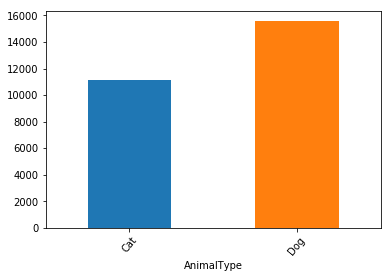

In [5]:
df_animals.groupby('AnimalType')['AnimalType'].count().plot(kind='bar', rot=50)

There are more dogs than cats in the shelter. Because their number is different, in our later investigation we'll either show normalized values or we'll separate cats and dogs in the questions we'll ask, so the numerical difference will not be a factor.

In [18]:
Dogs = df_animals['AnimalType']=='Dog'
Cats = ~Dogs

In [11]:
df_animals.nunique()

Name               6374
DateTime          22906
OutcomeType           5
OutcomeSubtype       16
AnimalType            2
SexuponOutcome        5
AgeuponOutcome       44
Breed              1380
Color               366
dtype: int64

We see there are too many different breeds. We'll probaly have to categorize this column so we get clearer understanding on it's infuence on outcome.

### How different outcomes are distributed?

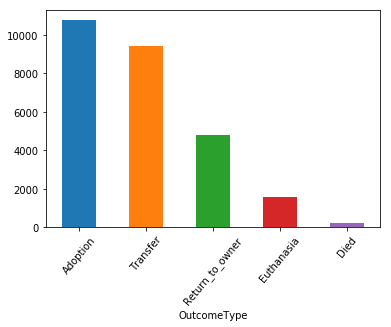

In [6]:
df_animals.groupby(['OutcomeType'])['AnimalType'].count().sort_values(ascending=False).plot(kind='bar', rot=50)

Most of the animals are being adopted or transfered. Let's see the outcome distribution by animal type:

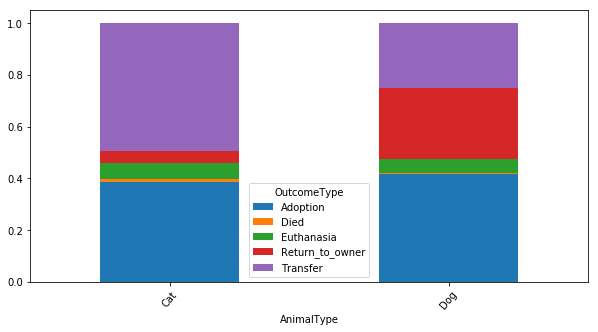

In [15]:
pd.crosstab(index=df_animals.AnimalType, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50, figsize=(10,5))

Both animal kinds have approximately same chances to be adopted (around 40%). More cats are being transferred, while more dogs are returned to owner. Cats are almost never returned to their owners. We can assume that most cats don't wear collars with personal info as dogs do, so when a cat gets lost it's very hard to find it's owner - unless the owner finds it by himself.

### Does breed influence on outcome?

We assume that not mixed animals will be adopted more. We'll add a new column to the dataset - "IsMixed":

In [22]:
def is_mixed(Breed):
    Breed = str(Breed)
    if Breed.find('Mix') >= 0:
        return 'Mix'
    return 'Not Mix'

df_animals['IsMixed'] = df_animals.Breed.apply(is_mixed)

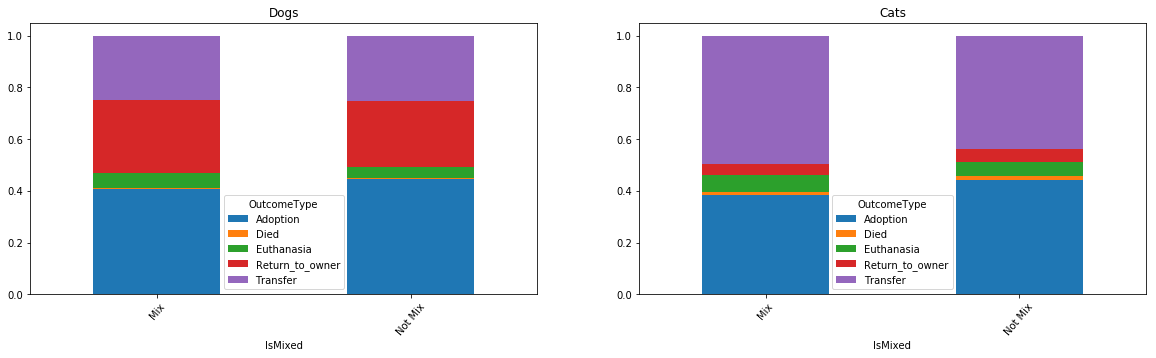

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
pd.crosstab(index=df_animals.IsMixed, columns=df_animals[Dogs].OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50, ax=ax1, title='Dogs')
pd.crosstab(index=df_animals.IsMixed, columns=df_animals[Cats].OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50, ax=ax2, title='Cats')

There is not a big difference between mixed and not mixed animals, so breed doesn't influence much on outcome, though the chances to be adopted are a bit higher for not mixed animals.

### How does age influence on outcome?

We have different age measurements, so first we'll calculate all ages in years and then assign them to age categories:

In [26]:
def get_age_years(AgeuponOutcome):
    AgeuponOutcome = str(AgeuponOutcome)
    if AgeuponOutcome == 'nan': return 0
    age = int(AgeuponOutcome.split(" ")[0])
    if AgeuponOutcome.find('year') > -1: return age
    if AgeuponOutcome.find('month') > -1: return age / 12
    if AgeuponOutcome.find('week') > -1: return age / 52
    if AgeuponOutcome.find('day') > -1: return age / 365
    else: return 0

df_animals['AgeInYears'] = df_animals.AgeuponOutcome.apply(get_age_years)

In [27]:
labels = ['baby', 'young', 'young adult', 'adult', 'old']
df_animals['AgeCategory'] = pd.cut(df_animals['AgeInYears'], bins=[0, 1, 5, 10, 15, 20], right=False, labels=labels)

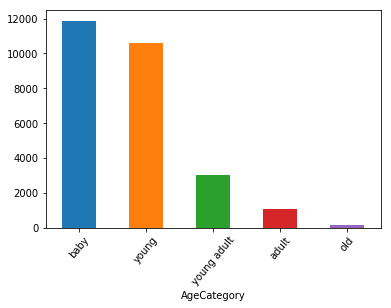

In [28]:
df_animals.groupby('AgeCategory')['AnimalType'].count().plot(kind='bar', rot=50)

We see that most of the animals in the shelter are babies or young.

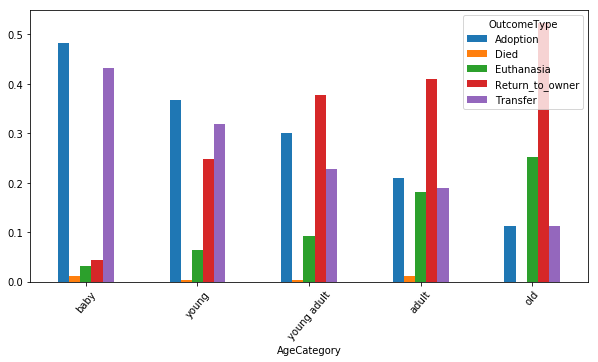

In [30]:
pd.crosstab(index=df_animals.AgeCategory, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', rot=50, figsize=(10, 5))

As expected, we can clearly see that as an animal gets older it has less chances to be adopted or transferred. The trend is exactly the opposite regarding "return to owner" outcome: older animals are returned to owners more often than younger ones - probably because owners that had an animal for a long time regret and take it back. Let's see if the influence of age differs between cats and dogs:

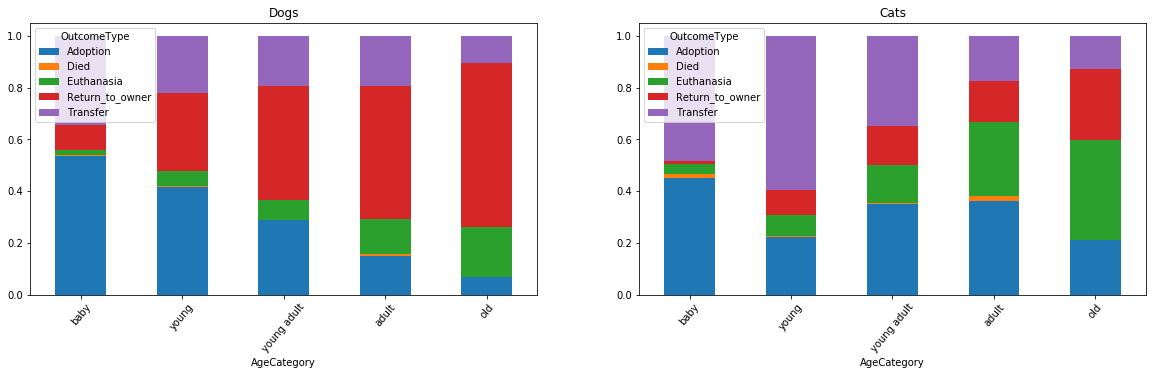

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
pd.crosstab(index=df_animals.AgeCategory, columns=df_animals[Dogs].OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50, ax=ax1, title='Dogs')
pd.crosstab(index=df_animals.AgeCategory, columns=df_animals[Cats].OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50, ax=ax2, title='Cats')

The trends are almost similar, with a little difference that older cats (young adults and adults) have a bit more chances to be adopted than older dogs. Most of old cats' outcome is euthanasia, while most old dogs are returned to owner. Most of young cats are being transferred.

### Let's investigate the connection between outcome type and outcome subtype:

In [15]:
df_animals.groupby('OutcomeSubtype')['OutcomeType'].nunique().sort_values(ascending=False).head()

OutcomeSubtype
Barn           2
Suffering      1
SCRP           1
Rabies Risk    1
Partner        1
Name: OutcomeType, dtype: int64

In [16]:
df_animals.loc[df_animals.OutcomeSubtype == 'Barn']

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,IsMixed,AgeInYears,AgeCategory
AnimalID,,,,,,,,,,,,
A695421,Percy,2015-01-26 14:55:00,Transfer,Barn,Cat,Neutered Male,3 years,Domestic Shorthair Mix,Black,Mix,3.0,young
A686921,NaN,2014-09-15 13:24:00,Adoption,Barn,Cat,Neutered Male,4 years,Domestic Shorthair Mix,Blue Tabby,Mix,4.0,young


We see that only if an outcome subtype is 'Barn' then there might be more than 1 outcome (either transfer or adoption). That's why if we know animal's OutcomeSubtype, we'll know the outcome in most of the cases.

### Let's see how sex influences on outcome:

We'll create 2 new columns out of SexuponOutcome column - Sex and IsIntact:

In [34]:
def get_sex(SexuponOutcome):
    SexuponOutcome = str(SexuponOutcome)
    if SexuponOutcome == 'nan': return 'Unknown'
    if SexuponOutcome.find('Male') > -1: return 'Male'
    if SexuponOutcome.find('Female') > -1: return 'Female'
    else: return 'Unknown'

df_animals['Sex'] = df_animals.SexuponOutcome.apply(get_sex)


In [35]:
df_animals['IsIntact'] = pd.np.where(df_animals.SexuponOutcome.str.contains("Unknown"), "Unknown",
                         pd.np.where(df_animals.SexuponOutcome.str.contains("Intact"), "Intact", "Neutered/Spayed"))

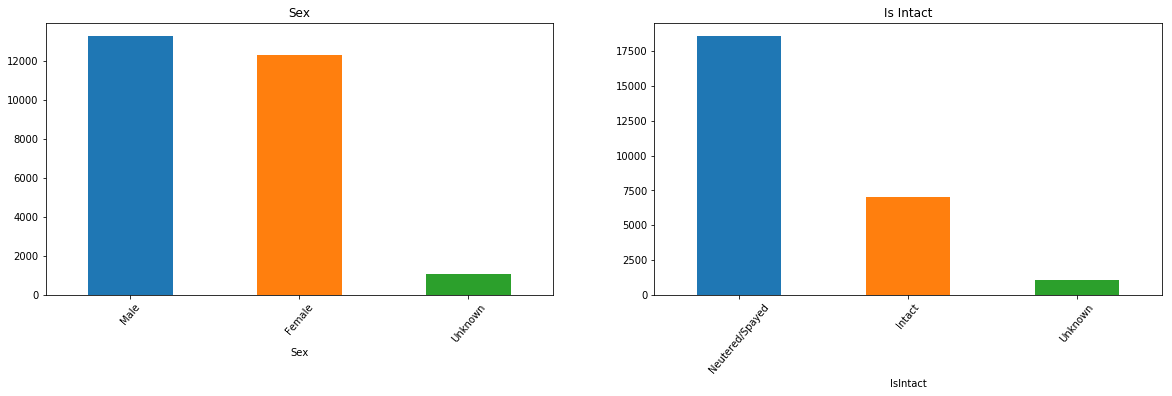

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
df_animals.groupby('Sex')['AnimalType'].count().sort_values(ascending=False).plot(kind='bar', rot=50, ax=ax1, title='Sex')
df_animals.groupby('IsIntact')['AnimalType'].count().sort_values(ascending=False).plot(kind='bar', rot=50, ax=ax2, title='Is Intact')

We have a bit more males than females and most of them are neutered/spayed. Now let's see if there is an influence on outcome:

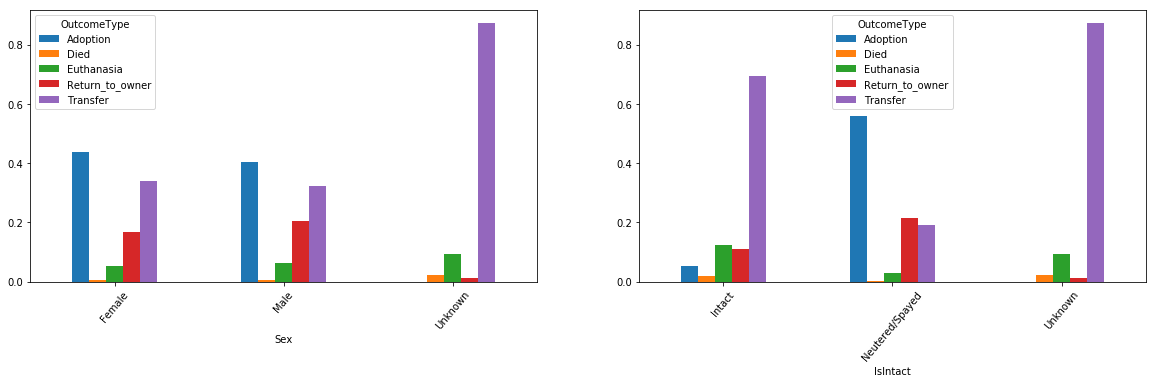

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
pd.crosstab(index=df_animals.Sex, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', rot=50, ax=ax1)
pd.crosstab(index=df_animals.IsIntact, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', rot=50, ax=ax2)

If sex is unknown there is a very high probability that the animal will be transferred. Neutered/spayed animals have much more probability to be adopted than intact ones.

### Some of the animals don't have names. We wonder if it matters:

In [41]:
df_animals['IsNamed'] = df_animals['Name'].notna()

In [42]:
df_animals.groupby(df_animals.IsNamed)['IsNamed'].count()

IsNamed
False     7673
True     19037
Name: IsNamed, dtype: int64

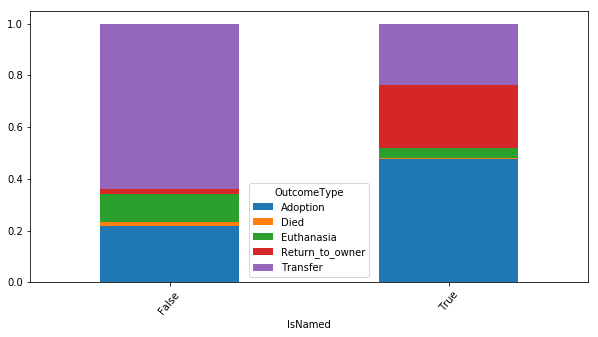

In [43]:
pd.crosstab(index=df_animals.IsNamed, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', stacked = True, rot=50, figsize=(10,5))

Interesting that most of the animals without names are being transferred, while most of the animals with names are being adopted. Maybe when a potential owner sees animal's name he gets personally attached to it and it's easier for him to decide to adopt it. Also, animals without names are almost never returned to their owners - well, this makes sense cause if an animal had owner most likely it also had a name.

### Every animal has a color. We'll devide the Color column into less categories so it will be easier to see it's impact on outcome type. We assume that the first part of the column is the main color, while the second part is secondary color, so we'll treat color only by the main one.

In [44]:
df_animals['ColorCategory'] = df_animals['Color'].str.split('/').str[0].str.split().str[0]

In [45]:
df_animals.groupby(df_animals.ColorCategory)['ColorCategory'].count().sort_values(ascending=False).head()

ColorCategory
Black    6641
Brown    5312
White    3343
Blue     2146
Tan      1674
Name: ColorCategory, dtype: int64

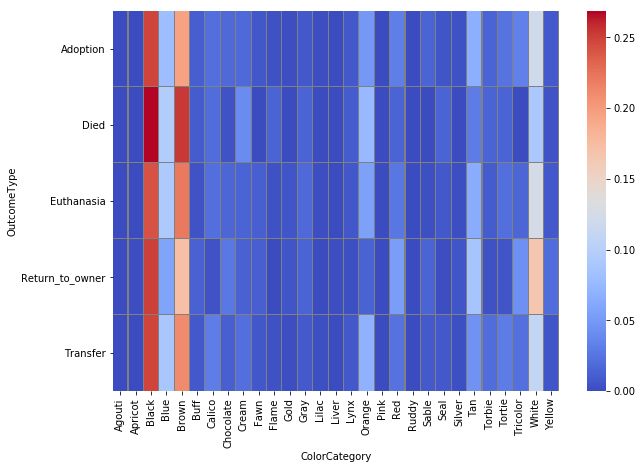

In [46]:
color_outcome = pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.ColorCategory, normalize='index')
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(ax=ax, data=color_outcome, 
            linecolor='grey', cmap='coolwarm',
            linewidths=.1)

In [27]:
df_animals.loc[df_animals.ColorCategory == 'Black'].groupby('OutcomeType')['OutcomeType'].count()

OutcomeType
Adoption           2679
Died                 53
Euthanasia          377
Return_to_owner    1197
Transfer           2340
Name: OutcomeType, dtype: int64

Most of the animals are black or brown so it makes sense that there will be a high correlation between these colors and outcome type.

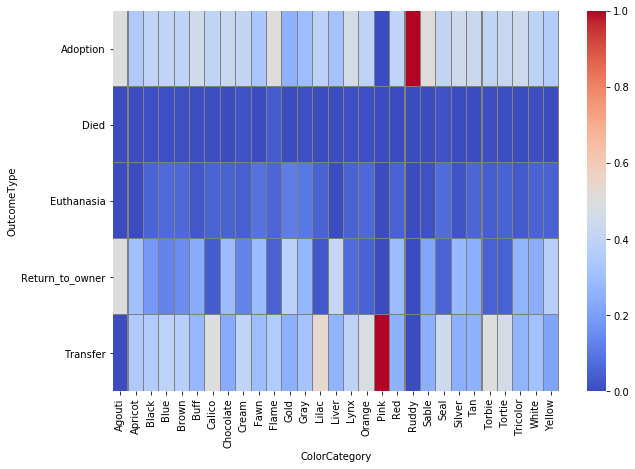

In [48]:
color_outcome = pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.ColorCategory, normalize='columns')
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(ax=ax, data=color_outcome, 
            linecolor='grey', cmap='coolwarm',
            linewidths=.1)

In [47]:
df_animals.loc[df_animals.ColorCategory == 'Pink'].groupby('OutcomeType')['OutcomeType'].count()

OutcomeType
Transfer    1
Name: OutcomeType, dtype: int64

In [49]:
df_animals.loc[df_animals.ColorCategory == 'Ruddy'].groupby('OutcomeType')['OutcomeType'].count()

OutcomeType
Adoption    1
Name: OutcomeType, dtype: int64

The high correlation between Pink color and Transfer, and between Ruddy color and Adoption is explained because we have only 1 record of each type.
The final conclusion is that here is no influence of color on outcome type.

### Let's investigate if we can get any information from the date and time of leaving the shelter:

In [50]:
df_animals['Year'] = df_animals['DateTime'].dt.year

In [71]:
df_animals['Month'] = df_animals['DateTime'].dt.month

In [72]:
df_animals['YearMonth'] = df_animals['DateTime'].map(lambda x: 100*x.year + x.month)

#### Let's see the outcome types trend over years:

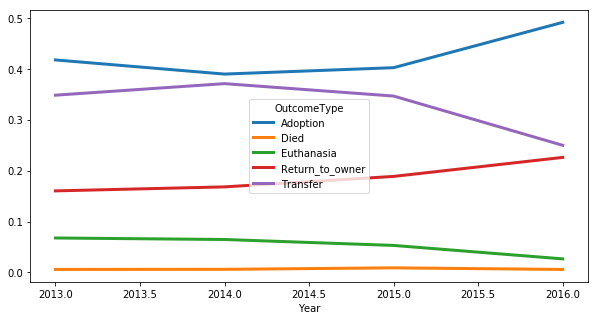

In [75]:
pd.crosstab(index=df_animals.Year, columns=df_animals.OutcomeType, normalize='index').plot(figsize=(10,5), linewidth=3)

We can see that as years pass by adoption and return to owner tendency are growing, while transfer and euthanasia tendency are decreasing.

#### Let's see how month influences on outcome:

#### Categorize Month:

In [74]:
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6:'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

df_animals['Month'] = df_animals['Month'].map(months).astype(CategoricalDtype(categories=months.values(), ordered=True))

df_animals['Month'].value_counts().sort_index()

January      2245
February     1850
March        1893
April        1922
May          2177
June         2412
July         2434
August       2179
September    1993
October      2549
November     2427
December     2629
Name: Month, dtype: int64

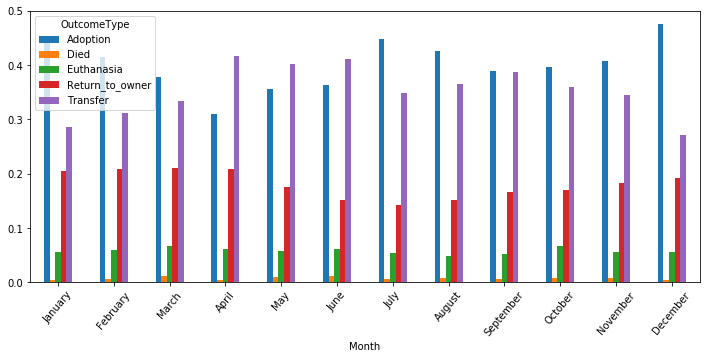

In [79]:
pd.crosstab(index=df_animals.Month, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', rot=50, figsize=(12,5))

It's a bit hard to see trends in the above chart, though we can already tell that in summer animals are being transferred more and less returned to owners. Adoption happens more during winter and summer - probably people have more free time during Christmas and summer holidays. Let's have a closer look how each outcome distrubutes through months:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000002EF2F27B70>,
      dtype=object)

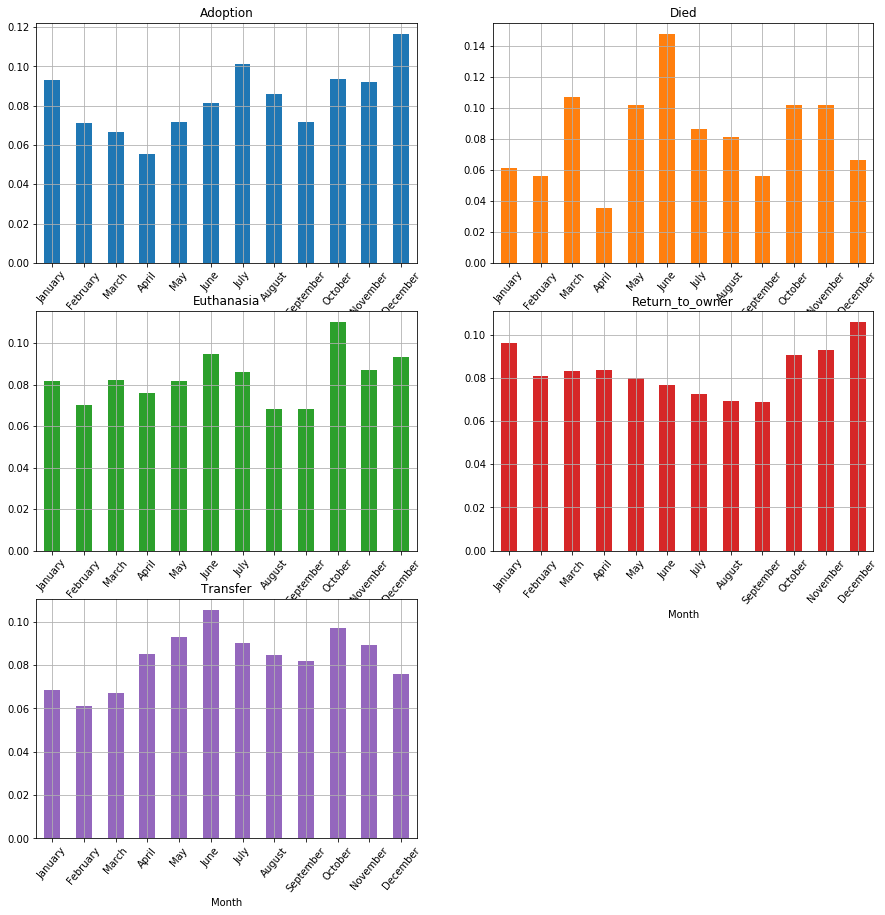

In [85]:
m = pd.crosstab(index=df_animals.Month, columns=df_animals.OutcomeType, normalize='columns').sort_index()

m.plot(kind='bar', subplots=True, layout=(3, 2), figsize=(15, 15), sharex=False, legend=False, rot=50, grid=True)

So here we can clearly see what we told above. In addition, we see that out of all animals who died - a lot of them died in June. 

#### Extract DayOfWeek from DateTime:

In [87]:
df_animals['DayOfWeek'] = df_animals['DateTime'].dt.weekday

days = {0:'Monday', 1: 'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

df_animals['DayOfWeek'] = df_animals['DayOfWeek'].map(days).astype(CategoricalDtype(categories=days.values(), ordered=True))

df_animals['DayOfWeek'].value_counts().sort_index()

Monday       3670
Tuesday      3787
Wednesday    3710
Thursday     3582
Friday       3637
Saturday     4182
Sunday       4142
Name: DayOfWeek, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000002EF0E55BE0>,
      dtype=object)

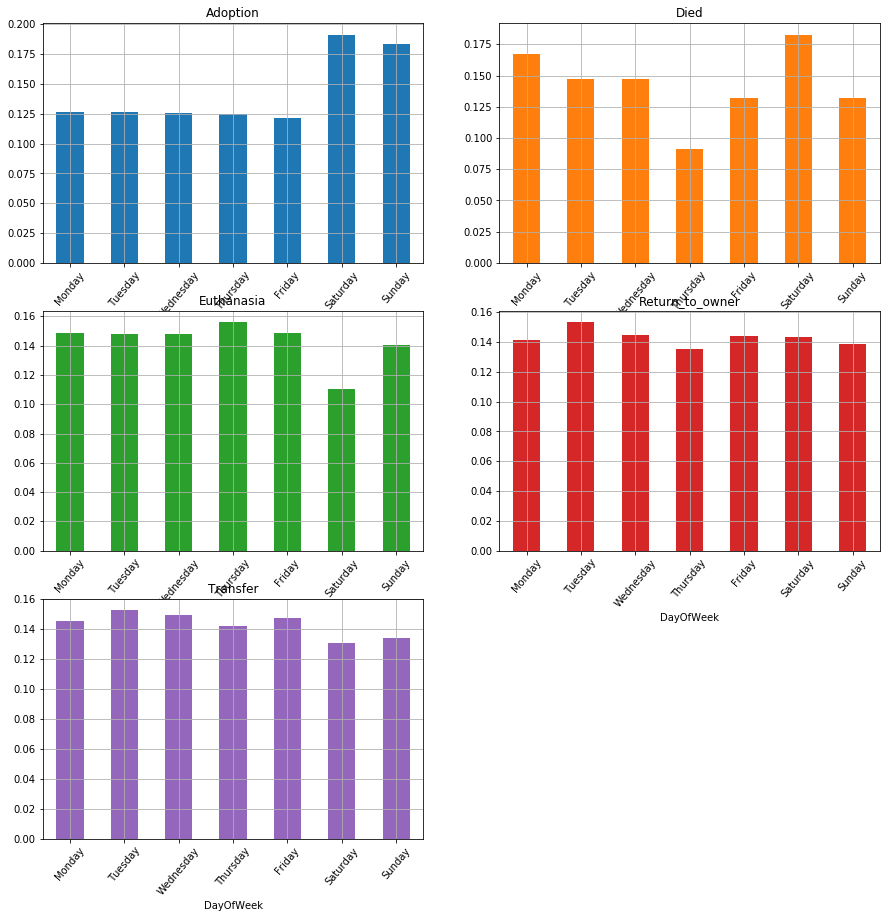

In [88]:
dow = pd.crosstab(index = df_animals.DayOfWeek, columns = df_animals.OutcomeType, normalize='columns').sort_index()

dow.plot(kind='bar', subplots=True, layout=(3, 2), figsize=(15, 15), sharex=False, legend=False, rot=50, grid=True)

On weekends (Saturday and Sunday) animals are adopted much more than on weekdays. In contrary, euthanasia is less common on weekends - probably due to the fact that potential owners visit the shelter more on weekends so the shelter staff is busy with them.

#### Extract IsHoliday from DateTime:

In [90]:
df_animals['Date'] = df_animals['DateTime'].dt.date

In [95]:
date_min = df_animals['Date'].min()
date_max = df_animals['Date'].max()

cal = calendar()
holidays = cal.holidays(start=date_min, end=date_max)

df_animals['IsHoliday'] = df_animals['Date'].isin(holidays.date)

df_animals.loc[df_animals['IsHoliday'] == True, ['Date', 'IsHoliday']].head()

,Date,IsHoliday
AnimalID,,
A718535,2016-01-01,True
A679259,2014-05-26,True
A720668,2016-02-15,True
A702563,2015-05-25,True
A698066,2015-07-03,True


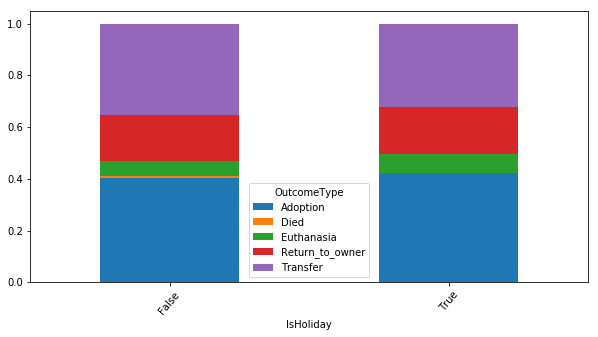

In [93]:
pd.crosstab(index=df_animals.IsHoliday, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50, figsize=(10,5))

Earlier we saw that during summer and winter animals are adopted more. Here, though, we see that there is no significant difference between holiday and non-holiday with regards to outcome. Maybe people come to the shelter not on the holiday itself but close to it.

# Some thoughts and further planning:

From the investigation above we found some features and their possible influence on outcome. There are still a few features we might need to investigate more: for example, we found no influence of animal color on outcome. But maybe our initial assumption of primary and secondary color was wrong and we need to categorize this column in a different way. We also saw there were plenty of bread types in the dataset. We categorized it only as mixed or non-mixed type but probably more precise categorization will be needed (there is breeds dictionary wikipedia). Regarding the results - it was much easier to see how different features influence on adoption, return to owner and transfer outcomes. Died and euthanasia outcomes didn't change much through all our questions, so it will be probably a bit harder to predict these outcomes.

Next step will be to prepare and run the classification model since we have a classification problem here: identifying to which of a set of categories (outcome types) a new observation belongs, on the basis of a training set of data containing observations whose category membership is known.